In [1]:
import time
import timeit
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

## Intro

Numpy is a numerical python library implementing almost everything you would want to
use from classical numerical linear algebra. It has a sister package that is closely
integrated in many submodules, and here we will cover a subset of both. The plan is to
briefly go over different data types, data layouts (arrays), functions, linear
algebra, and random number generation. There are many other libraries in Python for
doing deep learning which use quite similar APIs. Almost every concept we discuss in
this module would carry over to those frameworks. Among those frameworks, PyTorch is
the most popular deep learning framework in use today, but JAX is a terrific ecosystem
with much tighter coupling to Numpy.

## Data Types

This section covers the core data types in Numpy. These can be scalars or the 
core data types for arrays. We cover

* ints 
* uints 
* floats
* complex
  
We also look at type promotion in the case where different data types interact 
together. Generally the type promotion rules are that we promote lower order
types up to the larger container. So integers will become floats and small floats
will become big floats if that is necessary.

### Integers

Like Python provides several builtin types to represent numerical data, Numpy provides
many of its own types. A key difference is that all of numpy's types are fixed width,
meaning that they can overflow. For example:

In [2]:
i64 = np.array(1)
i64

array(1)

We can also ask for unsigned versions of integers, or cast data from one type into
another (dangerous if you aren't positive of domain restrictions). For example:

In [3]:
u64 = i64.astype(np.uint64)
u64

array(1, dtype=uint64)

The types can sometimes lead to surprising results if we aren't careful. Unlike Python's builtin integers, these fixed-width integers can wrap around to values in unexpected ways. Here are some examples:

In [4]:
print(f"{i64-2=}, {u64-2=}")
print(f"{u64 - 2 == 2**64 - 1}")
print(f"{(u64 - 2).astype(np.int64)}")

i64-2=np.int64(-1), u64-2=np.uint64(18446744073709551615)
True
-1


The signed integer uses its first bit to indicate the sign of the number and its
remaining 63 bits to represent the integer itself. So the range of representable
values are $-2^{63} \leq i_{64} < 2^{63}$. The unsigned bit does not reserve that first
position, so we have $0 \leq u_{64} < 2^{64}$. And as we see, integers can be recast between
types to be interpreted differently.

Because Numpy stores integers in fixed space, we can also overflow them with undefined
behavior. Consider now what happens when we shift the bit left by several positions:

In [5]:
print(i64 << 63)

-9223372036854775808


And although we will practically never need to *do* any of this in applications, it is
important to at least know these things could be issues if we're not careful. And it is 
especially important to know this behavior is different from what we get from Python's 
builtin types. Integers in Python are not necessarily the same as integers in Numpy.

### Floats

Floating point types are a similar story. By default, Numpy stores everything in
float64. It also aggressively promotes things internally to float64. So if we just
create a float


In [6]:
f64 = np.array(1.0)
print(f64, f64.dtype)

1.0 float64


we see it is using 64 bits. We could just as well store things in float32, in which
case we have

In [7]:
a = np.array(1.0, dtype=np.float32)
b = np.array(2.0, dtype=np.float32)
c = a + b
d = a * b
print(a, b, c, d)
print(a.dtype, b.dtype, c.dtype, d.dtype)

1.0 2.0 3.0 2.0
float32 float32 float32 float32


Numpy also supports complex numbers. Unless you're doing signal processing you
probably won't find much need for these. But some of you may want to use FFTs in your
research, in which case you will want to know that these exist and behave slightly
differently from other data types.

In [8]:
c64 = np.array(1.0 + 1.0j)
print(c64, c64.dtype)

(1+1j) complex128


For example, the absolute value of a complex number is actually the Euclidean distance in the
complex plane:

In [9]:
np.abs(c64), np.sqrt(1**2 + 1**2)

(np.float64(1.4142135623730951), np.float64(1.4142135623730951))

The full list of numpy's dtypes can be found at

   [Numpy Dtypes](https://numpy.org/devdocs/user/basics.types.html)


A last note: floats are imprecise approximations of the real number line. So we have

In [10]:
print(np.array(0.1) + np.array(0.2))

0.30000000000000004


This is a consequence of implementing floats using IEEE754, which is the most common
computational model of the real numbers. The main consequence of floating point arithmetic
is that we cannot always guarantee an operation is going to satisfy `equality` comparisons
as we might expect. Integers do not suffer this affliction, as the next example shows:

In [11]:
i64 == u64

np.True_

But floats are not the same story

In [12]:
a = np.array(0.1)
b = np.array(0.2)
c = np.array(0.3)
a + b == c, np.isclose(a + b, c)

(np.False_, np.True_)

In floating point, we have to instead ask *are these two things close*?

## Data Layouts (Arrays)

Topics:

- scalars
- vectors
- matrices
- tensors
- reshaping
- broadcasting

The reason we use Numpy isn't really to work on scalars. It's because we want to
use container types like n-dimensional arrays. We use numpy when we want to do matrix
math, or just to make some analysis in Python go faster than default Python.

A good starter is to look at the arange object. Python has `range(start, stop, step)`
objects. Numpy has `arange(start, stop, step)` objects. Note in both cases that we
use half open intervals [start, stop).

In [13]:
arange = np.arange(10)
print(arange)

[0 1 2 3 4 5 6 7 8 9]


These arrays are zero-indexed. The first element is accessed at arange[0], like:

In [14]:
print(arange[0])

0


Unlike Python's range object, our numpy arange supports instantiation by float. So the
following are equivalent:

In [15]:
aranged = np.arange(10.0)
arange_double = np.arange(10).astype(np.float64)
print(aranged)
print(arange_double)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


We compared the last two arrays by printing and looking at them. But we can actually
use comparison operators for the same purpose:

In [16]:
print(aranged < arange_double)
print(aranged == arange_double)
print(aranged > arange_double)

[False False False False False False False False False False]
[ True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False]


What happened here? Numpy does comparisons elementwise by _broadcasting_. We will
discuss broadcasting more momentarily. If we wanted to know if all of the elements
were the same, we could wrap the last comparison like so

In [17]:
print(np.all(aranged == arange_double))

True


Or if we wondered if any of the elements matched, we could instead ask

In [18]:
print(np.any(aranged == arange_double))

True


These comparisons may take some practice to get used to, but they become intuitive
over time (I promise!).

Another thing to be cognizant of is type promotion. Numpy _really likes to work in
float64_. And any time we combine data from different types, Numpy will promote to the
largest type necessary to store the results.

In [19]:
arangef = np.arange(10.0, dtype=np.float32)
aranged = np.arange(10.0, dtype=np.float64)
print((arangef + arangef).dtype)
print((arangef + aranged).dtype)

float32
float64


A last thing we want to discuss before looking at larger array types is broadcasting.
We saw with comparisons that numpy does elementwise comparison. The same is true if we
compare our scalars with our vectors.

In [20]:
i64 = np.array(5)
arange = np.arange(10)
print(arange == i64)

[False False False False False  True False False False False]


In [21]:
print(np.all(arange == i64))

False


In [22]:
print(np.any(arange == i64))

True


Or if we want to know where two things are equal, we can just ask:

In [23]:
print(np.where(arange == i64))

(array([5]),)


This returns an index of all of the places where two things are equal. Often, however
we want to know this so that we can replace some set of values with another set of
values. For example, we typically use `np.where` to replace writing a code snippet like

```python
for i in range(10):
    if arange[i] == i64:    # conditional
        arange[i] = 1       # true vals
    else:
        arange[i] = 0       # false vals
```

And doing that in `np.where`, we have 

```python
np.where(conditional, true_vals, false_vals)
```

In [24]:
print(np.where(arange == i64, 1, 0))

[0 0 0 0 0 1 0 0 0 0]


### Broadcasting

One of the great features of numpy is its declarative syntax, which includes
broadcasting of results when the shapes don't match but have compatible dimensions
somehow. Here are a few examples to try:

In [25]:
arange = np.arange(10)
arange + 5

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [26]:
arange * 5

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [27]:
arange / 5

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])

In [28]:
arange // 5

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### Reshaping arrays

Another wonderful feature of numpy arrays is that the shapes
are *mutable*. We can reshape things in any way we like to get
a more meaningful representation of our data:

In [29]:
arange = np.arange(10.0).reshape(2, 5)
arange

array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]])

Above we provided both dimensions explicitly, but we can also provide them
implicitly, like so:

In [30]:
arange = np.arange(10.0).reshape(2, -1)
#                     Note the -1  ^^^
arange

array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]])

We can make the arrays longer and reshape them into any configuration we like:

In [31]:
arange = np.arange(2.0 * 3.0 * 5.0 * 7.0).reshape(2, 3, 5, 7)
arange

array([[[[  0.,   1.,   2.,   3.,   4.,   5.,   6.],
         [  7.,   8.,   9.,  10.,  11.,  12.,  13.],
         [ 14.,  15.,  16.,  17.,  18.,  19.,  20.],
         [ 21.,  22.,  23.,  24.,  25.,  26.,  27.],
         [ 28.,  29.,  30.,  31.,  32.,  33.,  34.]],

        [[ 35.,  36.,  37.,  38.,  39.,  40.,  41.],
         [ 42.,  43.,  44.,  45.,  46.,  47.,  48.],
         [ 49.,  50.,  51.,  52.,  53.,  54.,  55.],
         [ 56.,  57.,  58.,  59.,  60.,  61.,  62.],
         [ 63.,  64.,  65.,  66.,  67.,  68.,  69.]],

        [[ 70.,  71.,  72.,  73.,  74.,  75.,  76.],
         [ 77.,  78.,  79.,  80.,  81.,  82.,  83.],
         [ 84.,  85.,  86.,  87.,  88.,  89.,  90.],
         [ 91.,  92.,  93.,  94.,  95.,  96.,  97.],
         [ 98.,  99., 100., 101., 102., 103., 104.]]],


       [[[105., 106., 107., 108., 109., 110., 111.],
         [112., 113., 114., 115., 116., 117., 118.],
         [119., 120., 121., 122., 123., 124., 125.],
         [126., 127., 128., 129., 130.

### Array Metadata

Arrays come with metadata: We can query the amount of storage used for the array, its
shape, and the dtype (as we saw with scalars):

In [32]:
arange = np.arange(2.0 * 3.0 * 5.0 * 7.0).reshape(2, 3, 5, 7)
print(arange.nbytes, arange.shape, arange.dtype)

1680 (2, 3, 5, 7) float64


Data can be reshaped in whatever way we want, and again we can query the new arrays
to learn what the shape and data types are. In most cases it is probably clear from
context what we want to use or do

In [33]:
arange_reshaped = arange.reshape(5, 2, 3, 7)
print(arange_reshaped.nbytes, arange_reshaped.shape, arange_reshaped.dtype)

1680 (5, 2, 3, 7) float64


In [34]:
print(arange_reshaped)

[[[[  0.   1.   2.   3.   4.   5.   6.]
   [  7.   8.   9.  10.  11.  12.  13.]
   [ 14.  15.  16.  17.  18.  19.  20.]]

  [[ 21.  22.  23.  24.  25.  26.  27.]
   [ 28.  29.  30.  31.  32.  33.  34.]
   [ 35.  36.  37.  38.  39.  40.  41.]]]


 [[[ 42.  43.  44.  45.  46.  47.  48.]
   [ 49.  50.  51.  52.  53.  54.  55.]
   [ 56.  57.  58.  59.  60.  61.  62.]]

  [[ 63.  64.  65.  66.  67.  68.  69.]
   [ 70.  71.  72.  73.  74.  75.  76.]
   [ 77.  78.  79.  80.  81.  82.  83.]]]


 [[[ 84.  85.  86.  87.  88.  89.  90.]
   [ 91.  92.  93.  94.  95.  96.  97.]
   [ 98.  99. 100. 101. 102. 103. 104.]]

  [[105. 106. 107. 108. 109. 110. 111.]
   [112. 113. 114. 115. 116. 117. 118.]
   [119. 120. 121. 122. 123. 124. 125.]]]


 [[[126. 127. 128. 129. 130. 131. 132.]
   [133. 134. 135. 136. 137. 138. 139.]
   [140. 141. 142. 143. 144. 145. 146.]]

  [[147. 148. 149. 150. 151. 152. 153.]
   [154. 155. 156. 157. 158. 159. 160.]
   [161. 162. 163. 164. 165. 166. 167.]]]


 [[[168. 169. 17

Finally, we can take subsets of data in the same way as we slice any other object in
Python; some examples:

In [35]:
arange = np.arange(10.0)

# slice elements 3:6 of arange
arange[3:6]

array([3., 4., 5.])

In [36]:
# Slice the first four elements of arange
arange[:4]

array([0., 1., 2., 3.])

In [37]:
# Slice from index 7 to the end of the array
arange[7:]

array([7., 8., 9.])

In [38]:
# Slice the last four elements of arange
arange[-4:]

array([6., 7., 8., 9.])

### Initializing Data

There are several ways in which we may want to create new arrays aside from the ones
shown. Some of these are with pseudo-random numbers, which we'll get to in a moment.
But there are several deterministic sequences we may want to create, like

In [39]:
# Generate a 3x3 empty matrix
np.empty((3, 3))

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [40]:
# Generate a 3x3 zeros matrix
np.zeros((3, 3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [41]:
# Generate a 3x3 ones matrix
np.ones((3, 3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

Here are a few more variations to try:

In [42]:
# Generate a sequence 0, 2, 4, ..., 30 using the arange function
# Note its signature: np.arange(start, stop, step)
np.arange(0.0, 31.0, 2)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30.])

In [43]:
# Generate a sequence 0.00, 0.01, ..., 0.98, 0.99, 1.00
# Recall np.arange(start, stop, step) allows floats!
np.arange(0.0, 1.01, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [44]:
# Generate the same sequence [0.00, 0.01, ..., 0.99, 1.00] using the
# np.linspace(start, stop, num) function
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

We can also index into arrays by conditional statements, as follows
(note this is related to the `np.where` functions from before):

In [45]:
arange[arange > 4]

array([5., 6., 7., 8., 9.])

In [46]:
arange[~(arange > 4)]

array([0., 1., 2., 3., 4.])

### Stacking data

The last major thing to do with arrays is to stack them in various ways.
There are several functions for doing this. I personally like to stick
to `np.concatenate` when I want to extend one array with another, and 
`np.stack` if I want to do anything else.

In [47]:
x = np.linspace(0, 1, 20)
concat = np.concatenate([x, x])
print(concat.shape)

concat

(40,)


array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ,
       0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [48]:
vstack = np.stack([x, x], axis=0)
print(vstack.shape)
vstack

(2, 20)


array([[0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
       [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]])

In [49]:
hstack = np.stack([x, x], axis=1)
print(hstack.shape)
hstack

(20, 2)


array([[0.        , 0.        ],
       [0.05263158, 0.05263158],
       [0.10526316, 0.10526316],
       [0.15789474, 0.15789474],
       [0.21052632, 0.21052632],
       [0.26315789, 0.26315789],
       [0.31578947, 0.31578947],
       [0.36842105, 0.36842105],
       [0.42105263, 0.42105263],
       [0.47368421, 0.47368421],
       [0.52631579, 0.52631579],
       [0.57894737, 0.57894737],
       [0.63157895, 0.63157895],
       [0.68421053, 0.68421053],
       [0.73684211, 0.73684211],
       [0.78947368, 0.78947368],
       [0.84210526, 0.84210526],
       [0.89473684, 0.89473684],
       [0.94736842, 0.94736842],
       [1.        , 1.        ]])

Or use these, but it's simpler to remember one function than it is to remember two or
three, so I prefer stack with an argument about how I want to stack things.

```python
vstack = np.vstack([x, x])
hstack = np.hstack([x[:, None], x[:, None]])
```

## Random Numbers

We present this module next because it is imperative to generating data in the
subsequent sections, so that we can work on less contrived examples than the ones we
have already seen.

### Random Seeds

We don't have to set random seeds, but it makes our analysis reproducible if we
implement something and want it to run deterministically. Everything we explore today
will be seeded. 

The right practice is to set seeds once at the start of a program and
then execute the program sequentially from start to finish. You will notice if you run
cells multiple times after setting the seed that the results become apparently random.
This is one of the primary reasons to strive for running stuff in scripts rather than
jupyter notebooks. That is a point that will be difficult to get across by the end of
the workshop, but it is one to consider if you continue to work in Python after this
workshop. For today, however, we are going to work in Jupyter notebooks because they
are interactive and nice for exploratory work.

The seed itself could be lots of things, including an empty argument. I always start
with a concrete value... Most of my test scripts start with seed 0. If you want to
have random but reproducible behavior, a better seed is to just grab the system time
in nanoseconds at program startup, like this:

In [50]:
# Get time in nanoseconds
seed = time.time_ns()

# Print the seed (decimal and hex)
print(f"{seed = }, (in hex: 0x{seed:x})")

rng = np.random.default_rng(seed)

seed = 1757836158096203393, (in hex: 0x186516ac20a95e81)


**But don't forget to save it when you're done!**


If we save that seed someplace then we can always reconstruct the program's execution
using the seeded value. This is *immensely* helpful for debugging programs that rely
on random number generation!

The random number generator supports generating all kinds of different distributions.
Here are some of them:

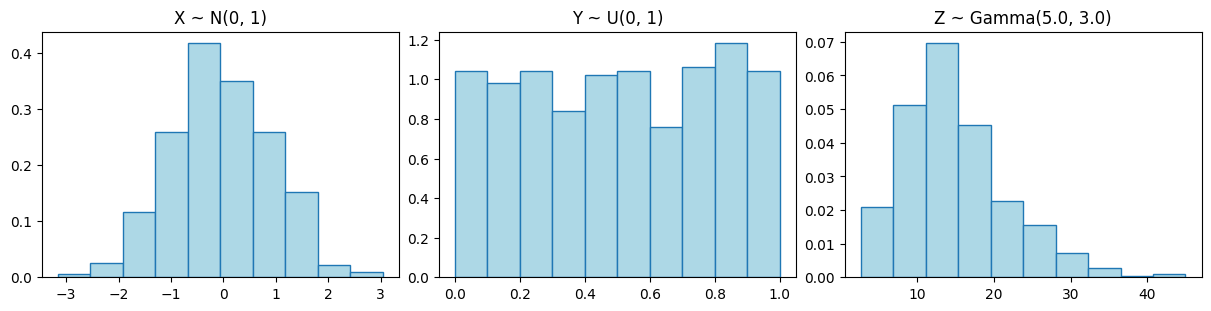

In [51]:
# Make three subplots with shape (1, 3), a large enough figsize to plot, and constrained layout
fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout="constrained")

# Generate 500 normal rvs and plot in ax[0]
normal_rvs = rng.normal(loc=0.0, scale=1.0, size=(500,))
ax[0].hist(normal_rvs, density=True, edgecolor="C0", facecolor="lightblue")
ax[0].set_title("X ~ N(0, 1)")

# Generate 500 uniform rvs and plot in ax[1]
uniform_rvs = rng.uniform(low=0.0, high=1.0, size=(500,))
ax[1].hist(uniform_rvs, density=True, edgecolor="C0", facecolor="lightblue")
ax[1].set_title("Y ~ U(0, 1)")

# Generate 500 gamma rvs with shape 5.0 and scale 3.0 and plot in ax[2]
gamma_rvs = rng.gamma(shape=5.0, scale=3.0, size=(500,))
ax[2].hist(gamma_rvs, density=True, edgecolor="C0", facecolor="lightblue")
ax[2].set_title("Z ~ Gamma(5.0, 3.0)")

# Show the results
plt.show()

There are also great helpers for randomly permuting data, like so:

In [52]:
# permute `normal_rvs[:10]`
normal_rvs_perm = rng.permutation(normal_rvs[:10], axis=0)

# Compare the two vectors
print(normal_rvs[:10])
print(normal_rvs_perm[:10])

[ 0.74266433  0.98824206 -2.52145378 -0.42764955  0.75958013  0.33286784
 -1.14579248 -0.63965492 -0.23746873 -0.22909381]
[-2.52145378 -0.63965492 -0.42764955 -1.14579248 -0.22909381  0.74266433
  0.98824206 -0.23746873  0.33286784  0.75958013]


If we wanted to permute *all* of our data by the same index, we could also
generate the permutation over the index 0..500:

In [53]:
# Generate a permutation array
permutation = rng.permutation(20)
permutation

array([17, 18, 14,  5,  9,  6,  2, 11, 10, 12,  4, 15, 16,  3,  1, 13,  7,
        8,  0, 19])

Now we could reindex all three vectors by this index. This is great for data splitting in several machine learning contexts.

A similar choice for doing the same thing is to use `rng.choice` (`np.random.choice`). The benefit of `rng.choice` is that it 
allows you to set the probability of drawing each datum and it allows repeated draws of the same data. Bootstrapped confidence
are an example of where this is good to know.

In [54]:
# Generate a sample using rng.choice
sample_idx = rng.choice(20, size=10, replace=False)
print(sample_idx)

[18  5  0 10  4  2  6 13  9  7]


As with the permutations, we can also just shuffle data in this way directly:

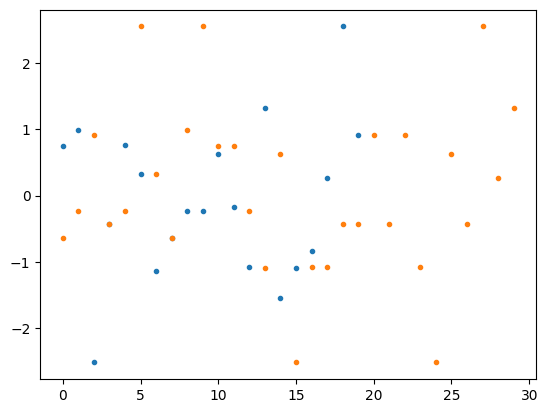

In [55]:
# Resample the data using rng.choice
normal_rvs_sample = rng.choice(normal_rvs[:20], size=30, replace=True)

plt.plot(normal_rvs[:20], ".")
plt.plot(normal_rvs_sample, ".")
plt.show()

And if what we want to do is genuinely randomizing the order of data, we can
call `rng.shuffle` (`np.random.shuffle`):

In [56]:
# Simulate a deck of cards:
deck = np.arange(52) + 1

# Shuffle the deck (done in place rather than returning a copy):
rng.shuffle(deck)

# Print
deck

array([ 3, 10, 50,  6, 16, 32, 17, 34, 22, 15, 23, 25,  4, 43, 14, 47,  5,
       27,  7, 33, 41, 24, 31, 45,  8, 42, 19, 44, 48, 11, 18, 28, 46, 12,
       37, 52,  9, 21, 13, 20, 40, 38, 39, 51, 30, 29, 35,  1, 26,  2, 49,
       36])

## Functions

We have already seen several functions. This is a short tour of the more obvious ones that we
didn't cover yet.

### Reductions and Summary Statistics

Since we just looked at random data, let's start the overview of functions by looking at 
summary statistics.

In [57]:
# Generate X ~ N(0, 1) with size (100, 30, 5)
x = rng.normal(size=(100, 30, 5))

To start, some functions are bound to the variables we are working with. For example,
we can calculate the mean, variance (var), standard deviation (std), minimum (min),
maximum (max), index of the min (argmin), and index of the max (argmax) using those
functions bound to the numpy namespace _or_ bound to the array objects themselves.

In [58]:
print(f"{np.mean(x)=:.5f} == {x.mean()=:.5f}")

np.mean(x)=-0.00544 == x.mean()=-0.00544


In [59]:
print(f"{np.var(x)=:.5f} == {x.var()=:.5f}")

np.var(x)=0.98534 == x.var()=0.98534


In [60]:
print(f"{np.std(x)=:.5f} == {x.std()=:.5f}")

np.std(x)=0.99264 == x.std()=0.99264


In [61]:
print(f"{np.min(x)=:.5f} == {x.min()=:.5f}")

np.min(x)=-3.54221 == x.min()=-3.54221


In [62]:
print(f"{np.max(x)=:.5f} == {x.max()=:.5f}")

np.max(x)=3.88767 == x.max()=3.88767


In [63]:
print(f"{np.argmin(x)=:.5f} == {x.argmin()=:.5f}")

np.argmin(x)=4557.00000 == x.argmin()=4557.00000


In [64]:
print(f"{np.argmax(x)=:.5f} == {x.argmax()=:.5f}")

np.argmax(x)=5983.00000 == x.argmax()=5983.00000


We can also apply these functions over specific axes. This operation will reduce the
shape of the array along that dimension, which is avoidable if we use `keepdims=True`.
Often that is unnecessary.

In [65]:
# Calculate summary stats along different axes and note the shapes/values
print(f"Calculating means for {x.shape=} along different axes")
print(
    f"{np.mean(x, axis=0).shape=},\n{np.mean(x, axis=1).shape=},\n{np.mean(x, axis=2).shape=}"
)

Calculating means for x.shape=(100, 30, 5) along different axes
np.mean(x, axis=0).shape=(30, 5),
np.mean(x, axis=1).shape=(100, 5),
np.mean(x, axis=2).shape=(100, 30)


### Other functions

But statistics aren't the only functions we may want to compute. Here is a plot of
sines, cosines, polynomials, and some of the other things you may generally want.

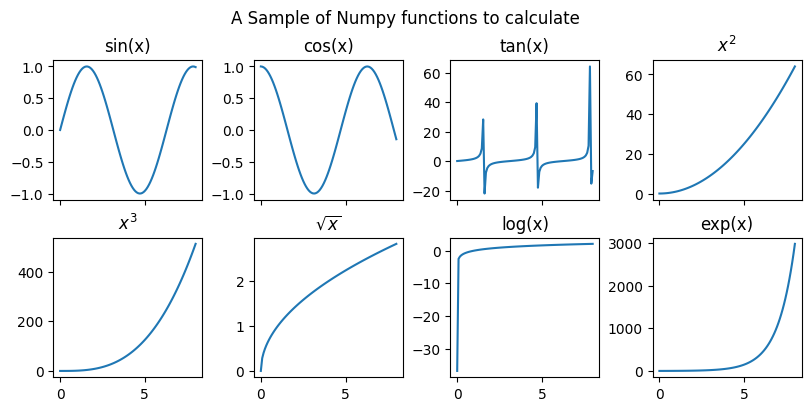

In [66]:
# define x on (0, 8] with 100 valus
x = np.linspace(1e-16, 8.0, 100)

# Make a 2,4 array of subplots:
fig, axes = plt.subplots(2, 4, figsize=(8, 4), layout="constrained", sharex=True)
ax = axes.flatten()

# sin(x)
ax[0].plot(x, np.sin(x))
ax[0].set_title("sin(x)")

# cos(x)
ax[1].plot(x, np.cos(x))
ax[1].set_title("cos(x)")

# tan(x)
ax[2].plot(x, np.tan(x))
ax[2].set_title("tan(x)")

# square(x)
ax[3].plot(x, np.square(x))
ax[3].set_title("$x^2$")

# cube(x)
ax[4].plot(x, x**3)
ax[4].set_title("$x^3$")

# sqrt(x)
ax[5].plot(x, np.sqrt(x))
ax[5].set_title("$\\sqrt{x}$")

# log(x)
ax[6].plot(x, np.log(x))
ax[6].set_title("log(x)")

# exp(x)
ax[7].plot(x, np.exp(x))
ax[7].set_title("exp(x)")

fig.suptitle("A Sample of Numpy functions to calculate")
plt.show()


And of course, all of the other operations you'd expect to work do work. They operate element-wise on data:

In [67]:
x = np.linspace(0, 1, 5)
y = np.sin(x)

np.sqrt(x) + 5 * y**2 / 3 + 2

array([2.        , 2.60201453, 3.09018819, 3.64041107, 4.18012236])

## Linear Algebra

And now for the thing Numpy really shines at (other than random number generation), linear algebra!

We can warm up with the dot product:
$$
    \langle u, v \rangle = u \cdot v = \sum_{k=1}^{n} u_i v_i.
$$

In [68]:
# Generate u, v ~ N(0, 1) of size 30
u, v = rng.normal(size=(2, 30))
np.dot(u, v)

np.float64(1.383755864579626)

Next we can solve linear systems of the form $A x = b$. Consider the system
$$
    \begin{bmatrix}
        0 & 1 & 2 \\
        1 & 4 & 2 \\
        2 & 1 & 1 \\
    \end{bmatrix}
    x = 
    \begin{bmatrix}
        8 \\ 15 \\ 7
    \end{bmatrix}.
$$
We'd like to solve this for $x$. The function `np.linalg.solve` does this for us straight away using an LU solve
under the hood.

In [69]:
A = np.array(
    [
        [0, 1, 2],
        [1, 4, 2],
        [2, 1, 1],
    ],
)
x = np.array([1, 2, 3])
b = np.dot(A, x)

A, x, b

(array([[0, 1, 2],
        [1, 4, 2],
        [2, 1, 1]]),
 array([1, 2, 3]),
 array([ 8, 15,  7]))

In [70]:
x_solved = np.linalg.solve(A, b)
print(f"||x_solved - x|| = {np.linalg.norm(x_solved - x):.4f}")

||x_solved - x|| = 0.0000


Some of you will have problems where the matrix has special structure (whether
you are initially aware of this or not). When such structure does exist, you can often
exploit it in the solver you are using. For example, here is a circulant embeddings
matrix. 

In [71]:
A = linalg.circulant(np.arange(500))
x = rng.normal(size=A.shape[0])
b = np.dot(A, x)

Now let's compare the time it takes to solve these using the generalized `np.linalg.solve` versus Scipy's 
specialized `scipy.linalg.solve_circulant`. 

In [72]:
%%timeit

# Solve with np.linalg.solve
linalg.solve(A, b)

3.39 ms ± 6.36 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
%%timeit 

# Solve with linalg.solve_circulant. 
# NOTE: solve_circulant uses the first column of A only with signature
# linalg.solve_circulant(c, b)
linalg.solve_circulant(A[:, 0], b)

26 μs ± 631 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


That's roughly a 10x speedup!

### Matrix Decompositions

There are several decompositions that are also supported in np.linalg and scipy.linalg
(imported as `from scipy import linalg`). Some of these that are common to least
squares problems are shown in `./ols.py`. Others we don't cover are the SVD and
eigen decompositions. These would be most relevant to PCA. However, good
implementations of these are typically provided in scikit-learn also via
`sklearn.decomposition`. Consider having a look at those if you are planning to do PCA
in your research.